# Compare the dbbmi data set with tigerpy and liesel

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os 

# Set path such that interpreter finds tigerpy
sys.path.append(os.path.join(os.getcwd(), ".."))

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate as tigerpyMVNDG

import liesel.model as lsl
import liesel.goose as gs
from liesel.distributions import MultivariateNormalDegenerate as lieselMVNDG
from liesel.goose.types import Array

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

rng = np.random.default_rng(42)

# Load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

## Data

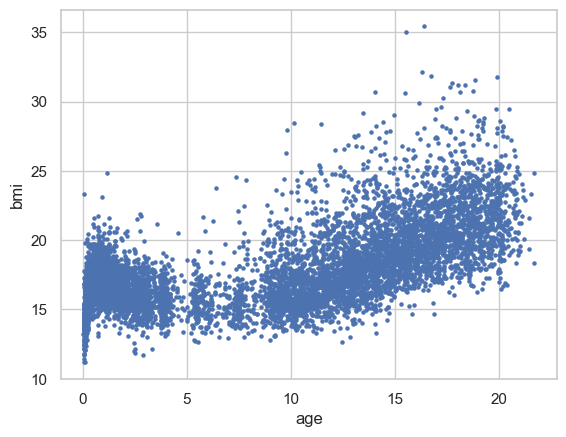

In [2]:
# Plot the data
sns.set_theme(style="whitegrid")
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

## Fit tigerpy

In [9]:
# Define a model with intercept 
# Set up design matrix for loc
X = tiger.Obs(name="X", intercept=True)
X.smooth(data=df["age"].to_numpy(), n_knots=25)
# If we combine fixed covariates and smooth covariates we need to center the the smooth effects first 
X.center()

# Set up design matrix for scale 
Z = tiger.Obs(name="Z", intercept=True)
Z.smooth(data=df["age"].to_numpy(), n_knots=25)
# If we combine fixed covariates and smooth covariates we need to center the the smooth effects first 
Z.center()

# Linear Predictor for the location ----
# Fixed coefficents 
# Set up beta_fixed hyperparameters 
beta_loc = tiger.Hyper(0.0, name="beta_loc")
beta_scale = tiger.Hyper(100.0, name="beta_scale")

# Set up parameters
beta_dist = tiger.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=df["bmi"].to_numpy().mean(), distribution=beta_dist, name="beta")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
smooth1_tau2_a = tiger.Hyper(1.0, name="smooth1_tau2_a")
smooth1_tau2_b = tiger.Hyper(0.00005, name="smooth1_tau2_b")
smooth1_tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=smooth1_tau2_a, scale=smooth1_tau2_b)
smooth1_tau2 = tiger.Param(value=jnp.array([1.0]), distribution=smooth1_tau2_dist, param_space="positive", name="smooth1_tau2")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
smooth1_loc = tiger.Hyper(np.zeros(X.smooth_dim_cent[0]), name="smooth1_loc")
smooth1_pen = tiger.Hyper(X.smooth_pen_mat_cent[0], name="smooth1_pen")
# Set up parameters
smooth1_dist = tiger.Dist(tigerpyMVNDG, loc=smooth1_loc, var=smooth1_tau2, pen=smooth1_pen)
smooth1 = tiger.Param(value=np.zeros(X.smooth_dim_cent[0]), distribution=smooth1_dist, name="smooth1")

# Set up the linear predictor
lpred_loc = tiger.Lpred(obs=X, beta_fixed=beta, beta_smooth=smooth1)

# Linear Predictor for the scale ----
# Fixed coefficents 
# Set up beta_fixed hyperparameters 
gamma_loc = tiger.Hyper(0.0, name="gamma_loc")
gamma_scale = tiger.Hyper(3.0, name="gamma_scale")

# Set up parameters
gamma_dist = tiger.Dist(tfjd.Normal, loc=gamma_loc, scale=gamma_scale)
gamma = tiger.Param(value=np.log(df["bmi"].to_numpy().std()), distribution=gamma_dist, name="gamma")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
smooth2_tau2_a = tiger.Hyper(1.0, name="smooth2_tau2_a")
smooth2_tau2_b = tiger.Hyper(0.00005, name="smooth2_tau2_b")
smooth2_tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=smooth2_tau2_a, scale=smooth2_tau2_b)
smooth2_tau2 = tiger.Param(value=jnp.array([1.0]), distribution=smooth2_tau2_dist, param_space="positive", name="smooth2_tau2")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
smooth2_loc = tiger.Hyper(np.zeros(Z.smooth_dim_cent[0]), name="smooth2_loc")
smooth2_pen = tiger.Hyper(Z.smooth_pen_mat_cent[0], name="smooth2_pen")
# Set up parameters
smooth2_dist = tiger.Dist(tigerpyMVNDG, loc=smooth2_loc, var=smooth2_tau2, pen=smooth2_pen)
smooth2 = tiger.Param(value=np.zeros(Z.smooth_dim_cent[0]), distribution=smooth2_dist, name="smooth2")

# ----
# Set up the linear predictor
lpred_scale = tiger.Lpred(obs=Z, gamma_fixed=gamma, gamma_smooth=smooth2, function=jnp.exp)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred_loc, scale=lpred_scale)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

In [10]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [15]:
q = bbvi.Bbvi(graph=graph,
              model_init=True,
              loc_prec=5.0,
              scale_prec=10.0)

key = jax.random.PRNGKey(27)
q.run_bbvi(key=key,
           learning_rate=0.01,
           grad_clip=1,
           threshold=1e-2,
           batch_size=512,
           train_share=0.8,
           num_var_samples=64,
           chunk_size=50,
           epochs=500)

Start optimization ...
Finished optimization.


In [16]:
# Location
# for fixed and smooth terms
beta_post = q.trans_var_params["beta"]["loc"]
smooth1_post = q.trans_var_params["smooth1"]["loc"]
loc_post = jnp.concatenate((beta_post, smooth1_post))
y_loc = X.design_matrix @ loc_post
# Scale 
gamma_post = q.trans_var_params["gamma"]["loc"]
smooth2_post = q.trans_var_params["smooth2"]["loc"]
scale_post = jnp.concatenate((gamma_post, smooth2_post))
y_scale = jnp.exp(Z.design_matrix @ scale_post)

In [17]:
pred_data_tiger = pd.DataFrame({"x": df["age"], "y":df["bmi"], "y_loc": y_loc, "y_scale": y_scale})
sort_pred_data_tiger = pred_data_tiger.sort_values("x")

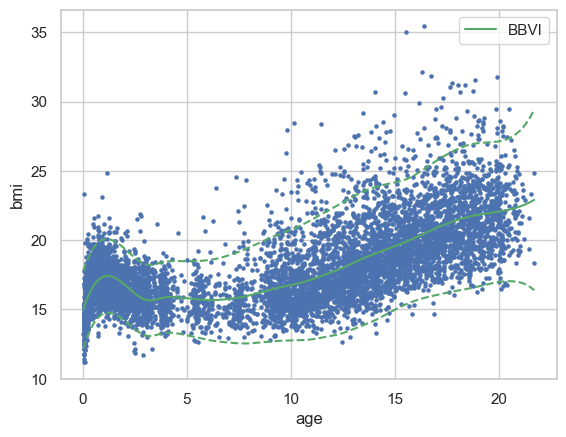

In [18]:
# plot the data
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y_loc"], color=sns.color_palette()[2], label = "BBVI")
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y_loc"] + 1.96*sort_pred_data_tiger["y_scale"], color=sns.color_palette()[2], linestyle='dashed')
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y_loc"] - 1.96*sort_pred_data_tiger["y_scale"], color=sns.color_palette()[2], linestyle='dashed')
plt.legend()
plt.show()

## Fit liesel

In [19]:
# Define Groups for the smooth parameter priors
class VarianceIG(lsl.Group):
    def __init__(
        self, name: str, a: float, b: float, start_value: float = 1000.0
    ) -> None:
        a_var = lsl.Var(a, name=f"{name}_a")
        b_var = lsl.Var(b, name=f"{name}_b")

        prior = lsl.Dist(tfjd.InverseGamma, concentration=a_var, scale=b_var)
        tau2 = lsl.param(start_value, distribution=prior, name=name)
        super().__init__(name=name, a=a_var, b=b_var, tau2=tau2)

class SplineCoef(lsl.Group):
    def __init__(self, name: str, penalty: Array, tau2: lsl.param) -> None:
        penalty_var = lsl.Var(penalty, name=f"{name}_penalty")

        evals = jax.numpy.linalg.eigvalsh(penalty)
        rank = lsl.Data(jnp.sum(evals > 0.0), _name=f"{name}_rank")
        _log_pdet = jnp.log(jnp.where(evals > 0.0, evals, 1.0)).sum()
        log_pdet = lsl.Data(_log_pdet, _name=f"{name}_log_pdet")

        prior = lsl.Dist(
            lieselMVNDG.from_penalty,
            loc=0.0,
            var=tau2,
            pen=penalty_var,
            rank=rank,
            log_pdet=log_pdet
        )
        start_value = np.zeros(np.shape(penalty)[-1], np.float32)

        coef = lsl.param(start_value, distribution=prior, name=name)

        super().__init__(name, coef=coef, penalty=penalty_var, tau2=tau2, rank=rank)

class PSpline(lsl.Group):
    def __init__(
        self, name, basis_matrix: Array, penalty: Array, tau2_group: lsl.Group
    ) -> None:
        coef_group = SplineCoef(
            name=f"{name}_coef", penalty=penalty, tau2=tau2_group["tau2"]
        )

        basis_matrix = lsl.obs(basis_matrix, name=f"{name}_basis_matrix")
        smooth = lsl.Var(
            lsl.Calc(jnp.dot, basis_matrix, coef_group["coef"]), name=name
        )

        group_vars = coef_group.nodes_and_vars | tau2_group.nodes_and_vars

        super().__init__(
            name=name,
            basis_matrix=basis_matrix,
            smooth=smooth,
            **group_vars
        )

In [20]:
# Set up model in liesel
# Loc branch 
# Fixed parameter prior
beta_loc = lsl.Var(0.0, name="beta_loc")
beta_scale = lsl.Var(100.0, name="beta_scale")

# Set up the fixed parameters
beta_dist = lsl.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = lsl.param(value=jnp.zeros((1,)), distribution=beta_dist, name="beta")

# Set up the smooth parameters
tau2_group_1 = VarianceIG(name="tau2_smooth_1", a=1.0, b=0.00005)

penalty = X.smooth_pen_mat_cent[0]
smooth_group_1 = PSpline(name="smooth_1", basis_matrix=X.design_mat_cent[1], penalty=penalty, tau2_group=tau2_group_1)

X_liesel = lsl.obs(X.fixed_data, name="X")

loc_fn = lambda x, beta, smooth_1: jnp.dot(x, beta) + smooth_1
loc_calc = lsl.Calc(loc_fn, x=X_liesel, beta=beta, smooth_1=smooth_group_1["smooth"])

loc = lsl.Var(loc_calc, name="loc")

# Scale branch 
# Fixed parameter prior
gamma_loc = lsl.Var(0.0, name="gamma_loc")
gamma_scale = lsl.Var(10.0, name="gamma_scale")

# Set up the fixed parameters
gamma_dist = lsl.Dist(tfjd.Normal, loc=gamma_loc, scale=gamma_scale)
gamma = lsl.param(value=jnp.zeros((1,)), distribution=gamma_dist, name="gamma")

Z_liesel = lsl.obs(Z.fixed_data, name="Z")

# Set up the smooth parameters
tau2_group_2 = VarianceIG(name="tau2_smooth_2", a=1.0, b=0.00005)

penalty = Z.smooth_pen_mat_cent[0]
smooth_group_2 = PSpline(name="smooth_2", basis_matrix=Z.design_mat_cent[1], penalty=penalty, tau2_group=tau2_group_2)

lpred_scale_fn = lambda z, gamma, smooth_2: jnp.dot(z, gamma) + smooth_2
lpred_scale_calc = lsl.Calc(lpred_scale_fn, z=Z_liesel, gamma=gamma, smooth_2=smooth_group_2["smooth"])
lpred_scale = lsl.Var(lpred_scale_calc, name="lpred_scale")

scale_fn = lambda s: jnp.exp(s)
scale_calc = lsl.Calc(scale_fn, s=lpred_scale)
scale = lsl.Var(scale_calc, name="scale")

response_dist = lsl.Dist(tfjd.Normal, loc=loc, scale=scale)
response = lsl.Var(df["bmi"].to_numpy(), distribution=response_dist, name="response")

In [21]:
gb = lsl.GraphBuilder().add(response)
model = gb.build_model()

liesel.model.model - INFO - Converted dtype of Data(name="response_value").value
liesel.model.model - INFO - Converted dtype of Data(name="smooth_2_coef_penalty_value").value
liesel.model.model - INFO - Converted dtype of Data(name="Z_value").value
liesel.model.model - INFO - Converted dtype of Data(name="smooth_1_coef_penalty_value").value
liesel.model.model - INFO - Converted dtype of Data(name="X_value").value


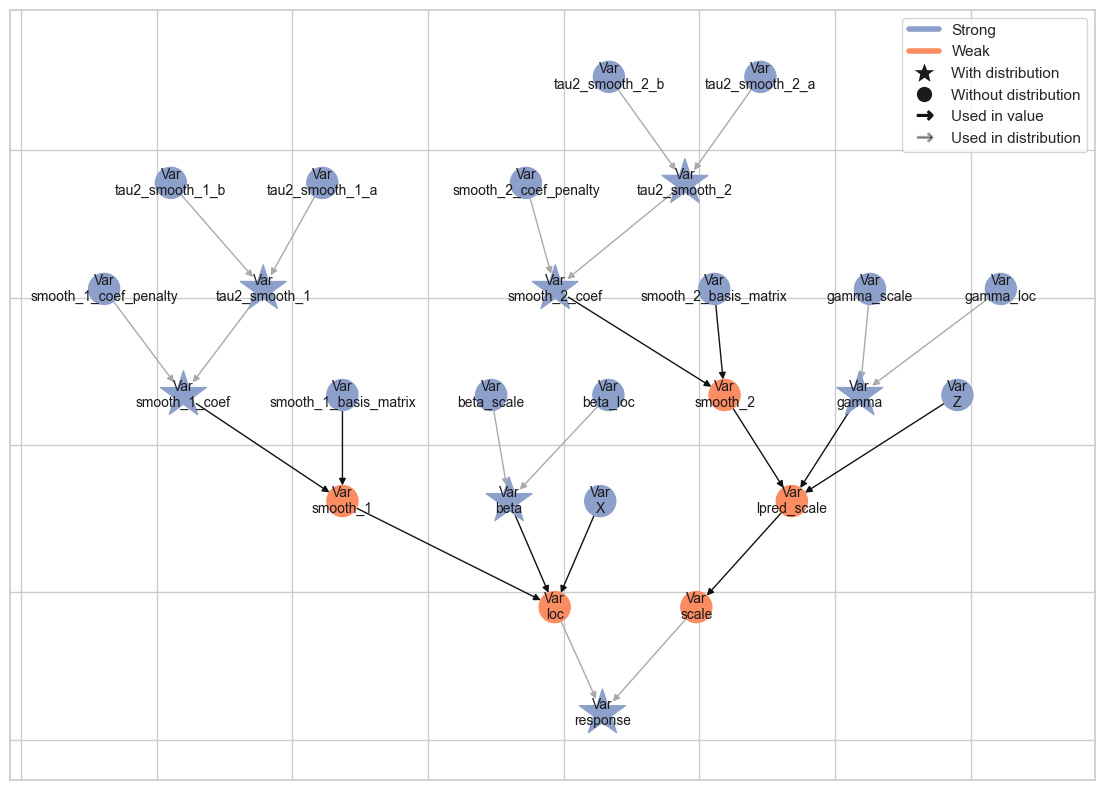

In [22]:
lsl.plot_vars(model)

In [23]:
def tau2_gibbs_kernel(p_spline: PSpline) -> gs.GibbsKernel:
    """Builds a Gibbs kernel for a smoothing parameter with an inverse gamma prior."""
    position_key = p_spline["tau2"].name

    def transition(prng_key, model_state):
        a_prior = p_spline.value_from(model_state, "a")
        b_prior = p_spline.value_from(model_state, "b")

        rank = p_spline.value_from(model_state, "rank")
        K = p_spline.value_from(model_state, "penalty")

        beta = p_spline.value_from(model_state, "coef")

        a_gibbs = jnp.squeeze(a_prior + 0.5 * rank)
        b_gibbs = jnp.squeeze(b_prior + 0.5 * (beta @ K @ beta))

        draw = b_gibbs / jax.random.gamma(prng_key, a_gibbs)

        return {position_key: draw}

    return gs.GibbsKernel([position_key], transition)

In [24]:
key, subkey = jax.random.split(key)
builder = gs.EngineBuilder(seed=subkey, num_chains=4)

builder.set_model(gs.LieselInterface(model))
builder.set_initial_values(model.state)

builder.add_kernel(tau2_gibbs_kernel(smooth_group_1))
builder.add_kernel(tau2_gibbs_kernel(smooth_group_2))
builder.add_kernel(gs.NUTSKernel(["beta"]))
builder.add_kernel(gs.NUTSKernel(["smooth_1_coef"]))
builder.add_kernel(gs.NUTSKernel(["gamma"]))
builder.add_kernel(gs.NUTSKernel(["smooth_2_coef"]))

builder.set_duration(warmup_duration=1000, posterior_duration=1000)

engine = builder.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done


In [25]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together


liesel.goose.engine - WARNING - Errors per chain for kernel_02: 70, 65, 73, 72 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 17, 18, 17, 20 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 74, 73, 73, 74 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_05: 53, 48, 57, 46 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 14, 4, 18, 17 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 6, 8, 6, 6 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 19, 8, 20, 21 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_05: 16, 6, 15, 6 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPT

In [26]:
results = engine.get_results()
gs.Summary(results)

Parameter summary:

                        kernel       mean        sd     q_0.05      q_0.5  \
parameter     index                                                         
beta          (0,)   kernel_02  18.026558  0.024247  17.987107  18.026629   
gamma         (0,)   kernel_04   0.659864  0.008274   0.646405   0.659768   
smooth_1_coef (0,)   kernel_03  -2.166229  0.080096  -2.298608  -2.166446   
              (1,)   kernel_03  -2.445528  0.070119  -2.560530  -2.445757   
              (2,)   kernel_03  -2.076383  0.139087  -2.297842  -2.077781   
              (3,)   kernel_03  -2.237189  0.186535  -2.555514  -2.235127   
              (4,)   kernel_03  -2.357174  0.155041  -2.609737  -2.355949   
              (5,)   kernel_03  -2.350394  0.177387  -2.643579  -2.348659   
              (6,)   kernel_03  -2.298006  0.184580  -2.611191  -2.295102   
              (7,)   kernel_03  -1.995018  0.170557  -2.271081  -1.995800   
              (8,)   kernel_03  -1.682334  0.174716  -1.960072  -1.687000   
              (9,)   kernel_03  -1.457702  0.139280  -1.684404  -1.455079   
              (10,)  kernel_03  -1.229351  0.136590  -1.452876  -1.230256   
              (11,)  kernel_03  -0.933736  0.142287  -1.164598  -0.932418   
              (12,)  kernel_03  -0.444758  0.144521  -0.677090  -0.444842   
              (13,)  kernel_03  -0.036876  0.141995  -0.274472  -0.034999   
              (14,)  kernel_03   0.435699  0.137470   0.204451   0.436618   
              (15,)  kernel_03   0.962971  0.138989   0.736704   0.959908   
              (16,)  kernel_03   1.399511  0.148213   1.153876   1.398682   
              (17,)  kernel_03   1.789505  0.143382   1.552540   1.789055   
              (18,)  kernel_03   2.311949  0.151693   2.061893   2.313573   
              (19,)  kernel_03   2.842613  0.146071   2.596976   2.842849   
              (20,)  kernel_03   3.327212  0.152185   3.081250   3.324617   
              (21,)  kernel_03   3.564568  0.141601   3.341059   3.559857   
              (22,)  kernel_03   3.807757  0.122555   3.602635   3.808310   
              (23,)  kernel_03   4.014915  0.180033   3.721067   4.011264   
smooth_2_coef (0,)   kernel_05  -0.555945  0.025912  -0.597970  -0.555602   
              (1,)   kernel_05  -0.190313  0.020827  -0.227213  -0.189003   
              (2,)   kernel_05  -0.345271  0.026567  -0.390722  -0.343608   
              (3,)   kernel_05  -0.268615  0.029011  -0.317434  -0.267094   
              (4,)   kernel_05  -0.218431  0.028793  -0.266752  -0.217546   
              (5,)   kernel_05  -0.161631  0.027757  -0.208541  -0.160502   
              (6,)   kernel_05  -0.102496  0.026666  -0.147196  -0.101873   
              (7,)   kernel_05  -0.044161  0.024868  -0.084958  -0.044223   
              (8,)   kernel_05   0.010485  0.022628  -0.026391   0.010427   
              (9,)   kernel_05   0.063484  0.020538   0.030239   0.063065   
              (10,)  kernel_05   0.111748  0.018792   0.081420   0.111269   
              (11,)  kernel_05   0.153844  0.018049   0.125216   0.153615   
              (12,)  kernel_05   0.190026  0.017678   0.161589   0.189484   
              (13,)  kernel_05   0.219792  0.017240   0.192780   0.219355   
              (14,)  kernel_05   0.243173  0.016933   0.216582   0.242888   
              (15,)  kernel_05   0.257613  0.016409   0.231399   0.257539   
              (16,)  kernel_05   0.264226  0.016821   0.236214   0.264408   
              (17,)  kernel_05   0.270018  0.017630   0.240161   0.270290   
              (18,)  kernel_05   0.278837  0.017577   0.250141   0.278730   
              (19,)  kernel_05   0.288283  0.017461   0.259942   0.288305   
              (20,)  kernel_05   0.294722  0.018291   0.265251   0.294405   
              (21,)  kernel_05   0.304013  0.019625   0.272312   0.304035   
              (22,)  kernel_05   0.295184  0.024052   0.256825   0.294898   
              (23,)  kernel_05   0.300564  0.032263  

In [80]:
1/0.000186

5376.344086021506

/Users/SebLorek/anaconda3/envs/thesis/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/SebLorek/anaconda3/envs/thesis/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


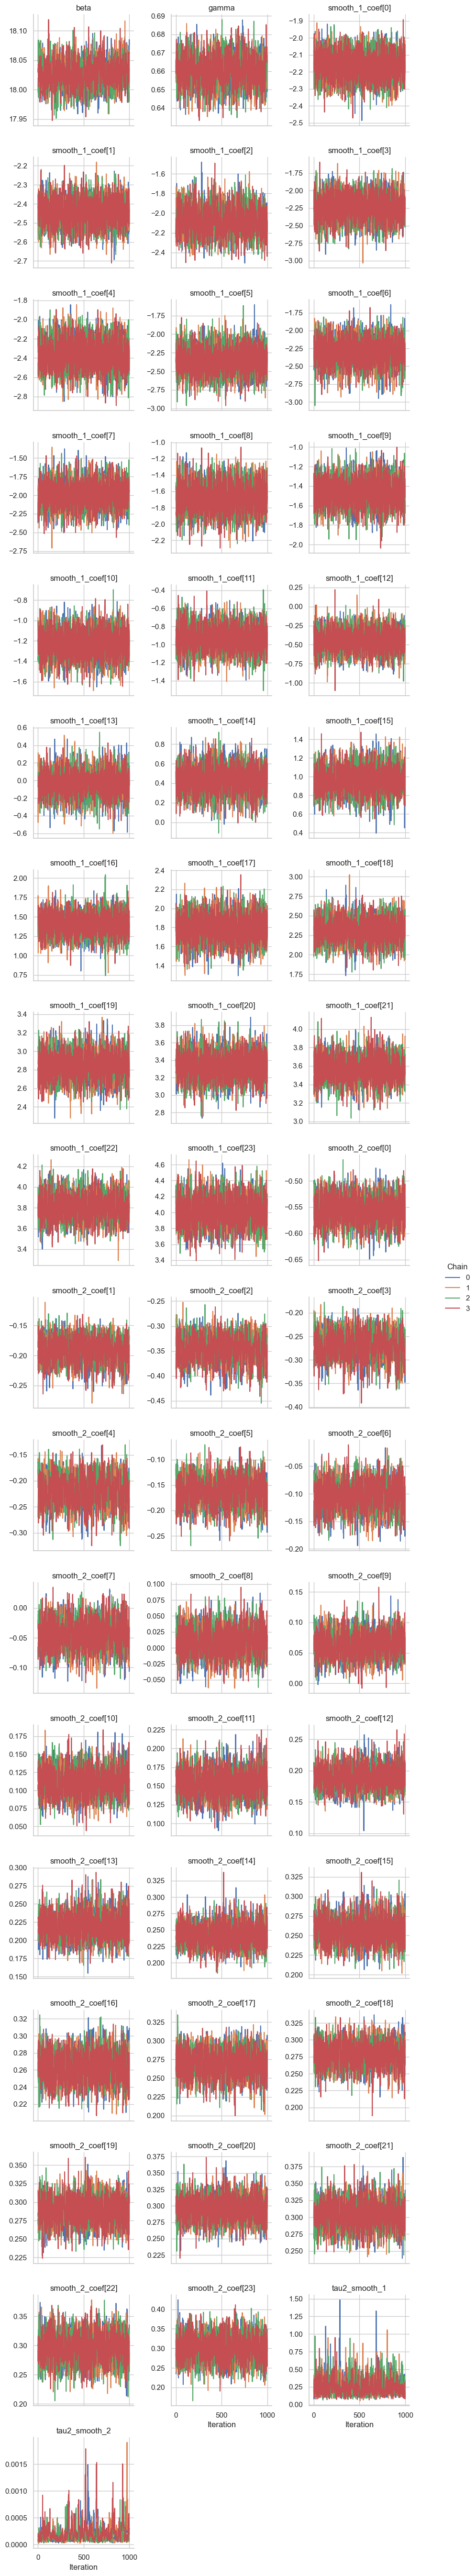

In [28]:
g = gs.plot_trace(results)

In [29]:
p = gs.Summary(results).quantities

In [73]:
beta = p["mean"]["beta"]
smooth1 = p["mean"]["smooth_1_coef"]
gamma = p["mean"]["gamma"]
smooth2 = p["mean"]["smooth_2_coef"]
coef_loc = jnp.concatenate((beta, smooth1))
coef_scale = jnp.concatenate((gamma, smooth2))
y_loc = X.design_matrix @ coef_loc
y_scale = jnp.exp(Z.design_matrix @ coef_scale)

pred_data_lsl = pd.DataFrame({"x": df["age"], "y": df["bmi"], "y_loc": y_loc, "y_scale": y_scale})
sort_pred_data_lsl = pred_data_lsl.sort_values("x")

In [76]:
# plot the data
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

plt.scatter(x=df["age"], y=df["bmi"], s=5)
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y_loc"], color=sns.color_palette()[2], label = "BBVI")
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y_loc"] + 1.96*sort_pred_data_tiger["y_scale"], color=sns.color_palette()[2], linestyle='dashed')
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y_loc"] - 1.96*sort_pred_data_tiger["y_scale"], color=sns.color_palette()[2], linestyle='dashed')
plt.plot(sort_pred_data_lsl["x"], sort_pred_data_lsl["y_loc"], color=sns.color_palette()[3], label = "MCMC")
plt.plot(sort_pred_data_lsl["x"], sort_pred_data_lsl["y_loc"] + 1.96*sort_pred_data_lsl["y_scale"], color=sns.color_palette()[3], linestyle='dashed')
plt.plot(sort_pred_data_lsl["x"], sort_pred_data_lsl["y_loc"] - 1.96*sort_pred_data_lsl["y_scale"], color=sns.color_palette()[3], linestyle='dashed')
plt.legend()


In [77]:
full_filepath = os.path.join(os.getcwd(), "../thesis/assets/other/plot_dbbmi.pdf")

In [78]:
full_filepath

'/Users/SebLorek/Desktop/uni/master_statistics/semester_4/master_thesis/bbvi/playground/../thesis/assets/other/plot_dbbmi.pdf'

In [79]:
plt.savefig(full_filepath)